In [0]:
import pandas as pd
import numpy as np
import nltk
import re
import sys
import random
import os
import torch
import math
import scipy.stats
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from string import punctuation
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm_notebook as tqdm
from google.colab import drive
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer

!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
nltk.download('stopwords')
nltk.download('wordnet')

sys.setrecursionlimit(1000000)

In [126]:
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/Memorability")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Text Preprocessing
 The following cells demonstrate the text preprocessing techniques outlined in section 4.1 of the report

In [127]:
#load video captions
video_captions = list(open('dev-set_video-captions.txt', 'r'))
video_captions = [i.split('\t') for i in video_captions]
video_captions = [[a, b.strip()] for a, b in video_captions]
video_captions = pd.DataFrame(video_captions, columns=['video', 'caption'])
video_captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [128]:
#normalise and lemmatise captions
wpt = nltk.WordPunctTokenizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

def norm_lemm_caption(cap):
    # replace hyphens
    cap = cap.replace('-',' ')
    cap = cap.strip()
    # tokenize caption
    tokens = wpt.tokenize(cap)
    # filter stopwords out of caption
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # lemmanise words in caption
    lemm_tokens = [wordnet_lemmatizer.lemmatize(token, pos="v") for token in filtered_tokens]
    # re-create document from tokens
    cap = ' '.join(lemm_tokens)
    return cap

#replace with normalised/lemmatised caption
norm_lemm_corpus = np.vectorize(norm_lemm_caption)
for index, row in video_captions.iterrows():
  video_captions.at[index, 'caption'] = norm_lemm_corpus(row.loc['caption'])

video_captions.head(5)

,video,caption
0,video3.webm,blonde woman massage tilt
1,video4.webm,roulette table spin ball closeup shoot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hover airport
4,video10.webm,couple relax picnic crane shoot


In [129]:
#load ground truth
ground_truth_file = 'dev-set_ground-truth.csv'
ground_truth = pd.read_csv(ground_truth_file)
ground_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [130]:
#get ground truth short and long term columns, convert to 2D list
ground_truth = pd.DataFrame(ground_truth, columns=['short-term_memorability','long-term_memorability']).values
ground_truth[0:5]

array([[0.924, 0.846],
       [0.923, 0.667],
       [0.863, 0.7  ],
       [0.922, 0.818],
       [0.95 , 0.9  ]])

In [131]:
# convert captions to list
captions_list = np.asarray(video_captions['caption'])

#gets a count of all words in the whole dataset
def get_counts(captions_list):
  #create massive string
  all_text = ' '.join(str(e) for e in captions_list)
  # create a list of the words
  words = all_text.split()
  
  # count all words using Counter and order
  count_words = Counter(words)
  total_words = len(words)
  word_counts = count_words.most_common(total_words)
  print('Counts of words in order:')
  print(word_counts)
  return word_counts

#assign an integer value to each word
def assign_ints(word_counts):
  #start from index 1 to facilitate 0 padding later
  vocab_to_int = {w:i+1 for i, (w,c) in enumerate(word_counts)}
  print()
  print('Words with assigned ints:')
  print(vocab_to_int)
  return vocab_to_int

#convert captions words to integers
def caption_text_to_int(captions_list, vocab_to_int):
  captions_int = []
  for caption in (str(e) for e in captions_list):
    r = [vocab_to_int[w] for w in caption.split()]
    captions_int.append(r)
  print()
  print('First five captions:')
  print(captions_int[0:5])
  return captions_int

counts = get_counts(captions_list)
vocab_to_int = assign_ints(counts)
captions_int = caption_text_to_int(captions_list,vocab_to_int)


Counts of words in order:
[('woman', 899), ('young', 724), ('man', 563), ('slow', 495), ('motion', 452), ('sit', 345), ('couple', 319), ('walk', 298), ('girl', 291), ('happy', 279), ('beach', 270), ('park', 262), ('close', 249), ('use', 239), ('camera', 230), ('look', 229), ('shoot', 227), ('smile', 223), ('two', 191), ('people', 189), ('water', 187), ('work', 186), ('tablet', 184), ('tree', 167), ('hand', 156), ('play', 153), ('view', 153), ('talk', 152), ('female', 150), ('computer', 149), ('eat', 148), ('run', 144), ('laptop', 139), ('sunset', 137), ('beautiful', 133), ('videoblocks', 131), ('stand', 131), ('city', 128), ('mother', 128), ('little', 126), ('family', 125), ('drink', 125), ('background', 124), ('home', 123), ('phone', 118), ('sea', 113), ('national', 112), ('african', 111), ('attractive', 111), ('snow', 106), ('fish', 105), ('field', 103), ('steadicamof', 102), ('modern', 101), ('street', 99), ('business', 98), ('road', 98), ('american', 97), ('swim', 96), ('boy', 96),

# Sequence Length and Padding
 Outlined in section 4.2 of the report

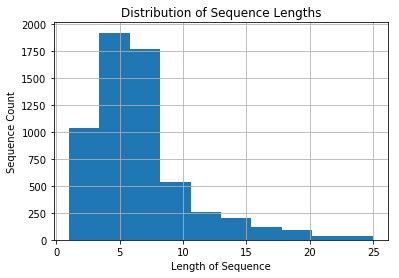

In [132]:
#breakdown of number of words per captions
#important for deciding the sequence length later
%matplotlib inline
cap_len = [len(x) for x in captions_int]
pd.Series(cap_len).hist()
plt.ylabel('Sequence Count')
plt.xlabel('Length of Sequence')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [133]:
# pad the caption sequences with 0's so that they're all the same length for the NN
def pad_captions(captions_int, seq_length):
    sequences = np.zeros((len(captions_int), seq_length), dtype = int)
    
    for i, caption in enumerate(captions_int):
        cap_len = len(caption)
        
        if cap_len <= seq_length:
            zeroes = list(np.zeros(seq_length-cap_len))
            new = zeroes+caption
        elif cap_len > seq_length:
            new = caption[0:seq_length]
        
        sequences[i,:] = np.array(new)
    
    return sequences

# sequence length of 10 was decided from the graph above
sequence_length = 10
sequences = pad_captions(captions_int, sequence_length)
print(sequences[0:5])

[[   0    0    0    0    0    0  678    1  196  317]
 [   0    0    0    0 1984   66  230  170   68   17]
 [   0    0    0    0    0    0    0    0  121  301]
 [   0    0    0    0    0    0  679  924 1042  152]
 [   0    0    0    0    0    7   85  493  221   17]]


# Data Splitting and Batching
 Outlined in section 4.3 of the report

In [0]:
#split into training, validation and test data
len_feat = len(sequences)

#training set size
split_frac = 0.8

train_x = sequences[0:int(split_frac*len_feat)]
train_y = ground_truth[0:int(split_frac*len_feat)]

remaining_x = sequences[int(split_frac*len_feat):]
remaining_y = ground_truth[int(split_frac*len_feat):]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]


In [0]:
#set seed for consistent accuracy prediction
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# use DataLoaders for each set with batch size 50
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Defining the Model and Training
 Outlined in section 4.4 of the report

In [0]:
train_on_gpu = torch.cuda.is_available()

#define model class
class LSTM_RNN(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5, ):

        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #LSTM layer - 200 layers deep
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # fully connected layer for 2 outputs
        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        
        #squash to 0 and 1
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # drop 30% of the outputs of the lstm layer
        out = self.dropout(lstm_out)
        
        # fully connected layer - call for each output
        #short mem
        out1 = self.fc1(out)
        #long mem
        out2 = self.fc2(out)
        
        # sigmoid function
        sig_out1 = self.sig(out1)
        sig_out2 = self.sig(out2)
        
        # reshape to be batch_size first
        sig_out1 = sig_out1.view(batch_size, -1)
        sig_out1 = sig_out1[:, -1] # get last batch of labels
        
        # reshape to be batch_size first
        sig_out2 = sig_out2.view(batch_size, -1)
        sig_out2 = sig_out2[:, -1] # get last batch of labels
            
        # return last sigmoid outputs and hidden state
        return sig_out1, sig_out2, hidden
    
    
    def init_hidden(self, batch_size):
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [139]:
# Instantiate the model with hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 2
embedding_dim = 400
hidden_dim = 200
n_layers = 2
net = LSTM_RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

LSTM_RNN(
  (embedding): Embedding(4297, 400)
  (lstm): LSTM(400, 200, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc1): Linear(in_features=200, out_features=2, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [140]:
# loss and optimization functions
lr=0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()

def train(loader):
  counter = 0
  
  # train for some number of epochs
  for e in range(epochs):
    
      # initialize hidden state
      h = net.init_hidden(batch_size)

      # batch loop
      for inputs, labels in loader:
          counter += 1

          if(train_on_gpu):
              inputs, labels = inputs.cuda(), labels.cuda()

          h = tuple([each.data for each in h])

          # zero accumulated gradients
          net.zero_grad()

          # get the output from the model
          inputs = inputs.type(torch.LongTensor)
          output1, output2, h = net(inputs, h)

          # calculate the loss and perform backprop

          # calculate loss for both short and long mem and add loss together
          loss1 = criterion(output1, labels[:,0].float())
          loss2 = criterion(output2, labels[:,1].float())
          loss = loss1 + loss2
          loss.backward()
          
          # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
          nn.utils.clip_grad_norm_(net.parameters(), clip)
          optimizer.step()

          # loss stats
          if counter % print_every == 0:
              # Get validation loss
              val_h = net.init_hidden(batch_size)
              val_losses = []
              net.eval()
              for inputs, labels in valid_loader:

                  val_h = tuple([each.data for each in val_h])

                  if(train_on_gpu):
                      inputs, labels = inputs.cuda(), labels.cuda()

                  inputs = inputs.type(torch.LongTensor)
                  val_output1, val_output2, val_h = net(inputs, val_h)
                  
                  # calculate val loss for both short and long mem and add loss together
                  val_loss1 = criterion(val_output1, labels[:,0].float())
                  val_loss2 = criterion(val_output2, labels[:,1].float())
                  val_loss = val_loss1 + val_loss2
                  #loss.backward()

                  val_losses.append(val_loss.item())

              net.train()
              print("Epoch: {}/{}...".format(e+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.6f}...".format(loss.item()),
                    "Val Loss: {:.6f}".format(np.mean(val_losses)))
              
              
train(train_loader)
torch.save(net.state_dict(), 'trained_model.t7')

Epoch: 2/4... Step: 100... Loss: 0.033241... Val Loss: 0.027199
Epoch: 3/4... Step: 200... Loss: 0.029681... Val Loss: 0.025975
Epoch: 4/4... Step: 300... Loss: 0.023471... Val Loss: 0.027591


In [0]:
net = LSTM_RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net.load_state_dict(torch.load('trained_model.t7'))

# Evaluation
 Outlined in section 5 of the report

In [0]:
# Create a function that takes in x's and y's
def spearmans_rank_correlation(xs, ys):
    
    # Calculate the rank of x's
    xranks = pd.Series(xs).rank()
    
    # Caclulate the ranking of the y's
    yranks = pd.Series(ys).rank()
    
    # Calculate Pearson's correlation coefficient on the ranked versions of the data
    return scipy.stats.pearsonr(xranks, yranks)

In [146]:
# Get test data loss and accuracy
xs1 = []
ys1 = []
xs2 = []
ys2 = []

def test(loader):
  test_losses = [] # track loss
  num_correct = 0

  # init hidden state
  h = net.init_hidden(batch_size)

  net.eval()
  # iterate over test data
  for inputs, labels in loader:

      h = tuple([each.data for each in h])

      if(train_on_gpu):
          inputs, labels = inputs.cuda(), labels.cuda()

      # get predicted outputs
      inputs = inputs.type(torch.LongTensor)
      output1, output2, h = net(inputs, h)

      # calculate loss
      # calculate test loss for both short and long mem and add losses together
      test_loss1 = criterion(output1, labels[:,0].float())
      test_loss2 = criterion(output2, labels[:,1].float())
      test_loss = test_loss1 + test_loss2
      test_losses.append(test_loss.item())

      pred1 = output1.squeeze()
      pred2 = output2.squeeze()

      xs1.extend(pred1.detach().numpy())
      xs2.extend(pred2.detach().numpy())
      ys1.extend(labels[:,0].detach().numpy())
      ys2.extend(labels[:,1].detach().numpy())
      

test(test_loader)

print('Spearman result for short term memorability scores:')
result = spearmans_rank_correlation(xs1,ys1)  
print(result[0])

print('Spearman result for long term memorability scores:')
result2 = spearmans_rank_correlation(xs2,ys2)  
print(result2[0])



Spearman result for short term memorability scores:
0.3844844775881982
Spearman result for long term memorability scores:
0.1521178922549887


In [147]:
#load test captions
test_captions = list(open('test-set-1_video-captions.txt', 'r'))
test_captions = [i.split('\t') for i in test_captions]
test_captions = [[a, b.strip()] for a, b in test_captions]
test_captions = pd.DataFrame(test_captions, columns=['video', 'caption'])

for index, row in test_captions.iterrows():
  test_captions.at[index, 'caption'] = norm_lemm_corpus(row.loc['caption'])

test_captions.head(5)

test_captions_list = np.asarray(test_captions['caption'])
test_caption_counts = get_counts(test_captions_list)
test_vocab_to_int = assign_ints(test_caption_counts)
test_captions_int = caption_text_to_int(test_captions_list,test_vocab_to_int)

test_sequences = pad_captions(test_captions_int, 10)

Counts of words in order:
[('woman', 303), ('young', 233), ('man', 169), ('slow', 133), ('motion', 116), ('girl', 108), ('couple', 107), ('sit', 106), ('park', 93), ('walk', 88), ('close', 86), ('happy', 85), ('shoot', 83), ('work', 77), ('smile', 76), ('use', 74), ('look', 72), ('camera', 70), ('beach', 70), ('talk', 61), ('tablet', 58), ('tree', 58), ('view', 58), ('water', 58), ('people', 57), ('two', 53), ('videoblocks', 53), ('run', 51), ('sunset', 49), ('hand', 47), ('eat', 47), ('computer', 47), ('city', 47), ('beautiful', 46), ('play', 45), ('female', 45), ('take', 42), ('little', 42), ('field', 40), ('family', 39), ('drink', 38), ('laptop', 37), ('phone', 37), ('fish', 37), ('light', 37), ('green', 35), ('business', 35), ('fly', 35), ('swim', 35), ('father', 34), ('background', 34), ('pan', 33), ('relax', 33), ('snow', 32), ('grass', 32), ('outdoors', 32), ('lie', 32), ('garden', 31), ('child', 31), ('farm', 31), ('national', 30), ('street', 30), ('night', 30), ('mountain', 30

# Test Set Predictions

In [150]:
batch_size = 50
# test conversion to tensor and pass into your model
test_set_data = torch.from_numpy(test_sequences)
test_set_loader = DataLoader(test_set_data, shuffle=True, batch_size=batch_size)

predictions1 = []
predictions2 = []

def predict(net, test_set_loader, sequence_length):
    
    net.eval()
    
    for inputs in test_set_loader:
      
      # initialize hidden state
      h = net.init_hidden(batch_size)

      if(train_on_gpu):
          inputs = inputs.cuda()

      # get the output from the model
      output1, output2, h = net(inputs, h)

      # convert output probabilities
      pred1 = output1.squeeze()
      pred2 = output2.squeeze()
      
      predictions1.extend(pred1.detach().numpy())
      predictions2.extend(pred2.detach().numpy())

        
predict(net, test_set_loader, 10)
print('Short term memorability scores:')
print(predictions1)
print('')
print('Long term memorability scores:')
print(predictions2)


Short term memorability scores:
[0.78755134, 0.80987084, 0.83669543, 0.8579852, 0.86472464, 0.806046, 0.85237825, 0.85936695, 0.81862307, 0.8268935, 0.86667645, 0.90261394, 0.8913475, 0.8580623, 0.8788206, 0.89102554, 0.8110081, 0.91167, 0.90042746, 0.8766002, 0.9014093, 0.8899993, 0.87956625, 0.77854115, 0.7813344, 0.84553146, 0.8869885, 0.8515446, 0.86584646, 0.83586514, 0.8843447, 0.8845598, 0.8241375, 0.84801733, 0.8704312, 0.88149047, 0.9044567, 0.9018155, 0.8730525, 0.8612203, 0.83323205, 0.83458406, 0.7788179, 0.8749046, 0.81505245, 0.8240797, 0.88372856, 0.9049552, 0.8437859, 0.9062645, 0.85968417, 0.87840563, 0.8378845, 0.8272271, 0.89852446, 0.87443453, 0.8758067, 0.89355415, 0.8618241, 0.89074606, 0.85576487, 0.81493217, 0.8547212, 0.8989951, 0.88204074, 0.87981707, 0.8630298, 0.8391783, 0.8905902, 0.875545, 0.83684194, 0.8690305, 0.8787454, 0.8443849, 0.89252776, 0.8851288, 0.8774054, 0.88068074, 0.8968866, 0.81846285, 0.84504086, 0.8430713, 0.8656201, 0.80977225, 0.8714927

In [0]:
# output to CSV
ground_truth_template_csv = 'ground_truth_template.csv'
ground_truth_template = pd.read_csv(ground_truth_template_csv)
ground_truth_template.head()

ground_truth_deirdre_corr = ground_truth_template

ground_truth_deirdre_corr['short-term_memorability'] \
= [predictions1[index] if math.isnan(mem) else mem for index, mem in enumerate(ground_truth_template['short-term_memorability'])]
ground_truth_deirdre_corr['long-term_memorability'] \
= [predictions2[index] if math.isnan(mem) else mem for index, mem in enumerate(ground_truth_template['long-term_memorability'])]
ground_truth_deirdre_corr.head(100)
ground_truth_deirdre_corr.to_csv('ground_truth_deirdre_corr.csv', sep=',', index=False)
  